In [1]:
import matplotlib

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 500)
import seaborn as sns
matplotlib.rcParams['figure.figsize'] = (30,30)
from IPython.display import Image
from pydotplus import graph_from_dot_data

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OneHotEncoder
# from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz

from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
df = pd.read_csv('df.csv')

In [3]:
df

,Unnamed: 0,matchID,date,day_of_week,name,league,game_number,score,length_outs,day_night,park_id,attendance,length_minutes,line_score,at_bats,hits,doubles,triples,homeruns,rbi,sacrifice_hits,sacrifice_flies,hit_by_pitch,walks,intentional walks,...,errors,passed_balls,double_plays,triple_plays,hp_umpire_id,1b_umpire_id,2b_umpire_id,3b_umpire_id,manager_id,winning_pitcher_id,losing_pitcher_id,saving_pitcher_id,winning_rbi_batter_id,starting_pitcher_id,player_1_id,player_2_id,player_3_id,player_4_id,player_5_id,player_6_id,player_7_id,player_8_id,player_9_id,winning_team,winner
0,0,0,19460416,Tue,DET,AL,1,2,51,D,DET04,52900.0,110.0,01010000x,28.0,6.0,1.0,0.0,1.0,2.0,0.0,0.0,0.0,5.0,1.0,...,0.0,0.0,1.0,0.0,mcgob901,rue-j901,NaN,passa901,oneis101,newhh101,pottn102,NaN,greeh102,newhh101,lakee101,mayoe101,mccob101,greeh102,waked101,mullp101,higgm101,richp101,newhh101,Home,1.0
1,10,10,19460417,Wed,PHA,AL,2,7,51,D,PHI11,11901.0,120.0,10000051x,31.0,9.0,2.0,1.0,0.0,6.0,3.0,0.0,0.0,2.0,0.0,...,0.0,0.0,2.0,0.0,boyej901,joner901,NaN,romme101,mackc101,newsb101,gumpr101,NaN,kellg102,newsb101,garrf101,peckh101,wallj102,chaps101,mcqug101,rosab101,kellg102,handg101,newsb101,Home,1.0
2,16,16,19460418,Thu,DET,AL,3,6,51,D,DET04,16469.0,118.0,10030011x,36.0,12.0,3.0,1.0,0.0,6.0,0.0,0.0,0.0,6.0,1.0,...,0.0,0.0,0.0,0.0,passa901,mcgob901,NaN,rue-j901,oneis101,benta101,galed101,NaN,greeh102,benta101,lakee101,mayoe101,mccob101,greeh102,waked101,mullp101,higgm101,richp101,benta101,Home,1.0
3,19,19,19460418,Thu,BRO,NL,3,8,51,D,NYC15,31825.0,136.0,00512000x,32.0,9.0,1.0,2.0,0.0,6.0,0.0,0.0,0.0,4.0,0.0,...,1.0,0.0,1.0,0.0,dunnt901,henlb101,mageg901,stewb901,durol101,lombv101,feldh101,NaN,whitd103,lombv101,whitd103,hermb101,reisp101,steve101,hermg101,furic101,andef102,reesp101,lombv101,Home,1.0
4,23,23,19460420,Sat,BOS,AL,4,2,51,D,BOS07,30446.0,94.0,10000001x,24.0,2.0,0.0,0.0,1.0,2.0,1.0,0.0,0.0,6.0,0.0,...,0.0,0.0,1.0,0.0,romme101,boyej901,NaN,joner901,cronj101,hught102,fowld101,NaN,peskj101,hught102,dimad101,peskj101,willt103,doerb101,yorkr101,metkg101,andre103,wagnh102,hught102,Home,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167739,83866,94926,20161002,Sun,CIN,NL,162,4,54,D,CIN09,32587.0,198.0,300100000,32.0,6.0,2.0,0.0,0.0,4.0,0.0,0.0,1.0,3.0,0.0,...,0.0,0.0,1.0,0.0,whitc901,belld901,morag901,hallt901,pricb801,grimj002,igler001,edwac001,szczm001,stepr002,peraj003,dejei002,vottj001,duvaa001,sches001,suare001,barnt001,rendt001,stepr002,Visitor,0.0
167740,83867,94927,20161002,Sun,COL,NL,162,4,60,D,DEN02,27762.0,203.0,1100100010,41.0,13.0,4.0,0.0,1.0,4.0,1.0,0.0,1.0,3.0,0.0,...,0.0,0.0,0.0,0.0,barrs901,woodt901,randt901,ortir901,weisw001,thort001,rusic001,knebc001,susaa001,marqg001,blacc001,dahld001,arenn001,gonzc001,murpt002,pattj005,valap001,adamc001,marqg001,Visitor,0.0
167741,83868,94928,20161002,Sun,PHI,NL,162,5,51,D,PHI13,36935.0,159.0,00100031x,33.0,10.0,1.0,0.0,0.0,3.0,0.0,1.0,0.0,2.0,0.0,...,0.0,0.0,1.0,0.0,barkl901,herna901,barrt901,littw901,mackp101,murrc002,goede001,nerih001,hernc005,eickj001,hernc005,parej002,herro001,franm004,howar001,ruppc001,blana001,altha001,eickj001,Visitor,0.0
167742,83870,94930,20161002,Sun,SLN,NL,162,10,51,D,STL10,44615.0,192.0,00100360x,36.0,12.0,2.0,0.0,1.0,10.0,0.0,2.0,0.0,4.0,0.0,...,0.0,0.0,1.0,0.0,cuzzp901,ticht901,vanol901,marqa901,mathm001,broxj001,nicaj001,NaN,piscs001,waina001,carpm002,diaza003,moliy001,piscs001,peraj001,mossb001,gyorj001,gricr001,waina001,Visitor,0.0


In [4]:
for column in df.columns:
    if '_id' in column:
        df.drop(columns=column, inplace=True)

# Feature selection

Look at the vif and run a decision tree to find the feature importance to help select those.

In [5]:
y = df['winner']
X = df.drop(columns=['Unnamed: 0', 'winner', 'league', 'winning_team', 'line_score', 'day_night','name'])

In [6]:
X = X.loc[:, :'triple_plays']

In [9]:
X

,date,game_number,attendance,length_minutes,hits,doubles,triples,homeruns,rbi,sacrifice_hits,sacrifice_flies,hit_by_pitch,walks,intentional walks,strikeouts,stolen_bases,caught_stealing,grounded_into_double,first_catcher_interference,left_on_base,pitchers_used,individual_earned_runs,team_earned_runs,wild_pitches,balks,assists,errors,passed_balls,double_plays,triple_plays,Fri,Mon,Sat,Sun,Thu,Tue,Wed
0,19460416,1,52900.0,110.0,6.0,1.0,0.0,1.0,2.0,0.0,0.0,0.0,5.0,1.0,4.0,0.0,0.0,2.0,0.0,7.0,1.0,1.0,1.0,0.0,0.0,13.0,0.0,0.0,1.0,0.0,0,0,0,0,0,1,0
1,19460417,2,11901.0,120.0,9.0,2.0,1.0,0.0,6.0,3.0,0.0,0.0,2.0,0.0,3.0,1.0,0.0,0.0,0.0,5.0,1.0,1.0,1.0,0.0,0.0,10.0,0.0,0.0,2.0,0.0,0,0,0,0,0,0,1
2,19460418,3,16469.0,118.0,12.0,3.0,1.0,0.0,6.0,0.0,0.0,0.0,6.0,1.0,5.0,0.0,0.0,0.0,0.0,12.0,1.0,1.0,1.0,0.0,0.0,17.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,0
3,19460418,3,31825.0,136.0,9.0,1.0,2.0,0.0,6.0,0.0,0.0,0.0,4.0,0.0,5.0,5.0,1.0,0.0,0.0,4.0,1.0,1.0,1.0,0.0,0.0,5.0,1.0,0.0,1.0,0.0,0,0,0,0,1,0,0
4,19460420,4,30446.0,94.0,2.0,0.0,0.0,1.0,2.0,1.0,0.0,0.0,6.0,0.0,3.0,0.0,0.0,0.0,0.0,5.0,1.0,1.0,1.0,0.0,0.0,8.0,0.0,0.0,1.0,0.0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167739,20161002,162,32587.0,198.0,6.0,2.0,0.0,0.0,4.0,0.0,0.0,1.0,3.0,0.0,7.0,0.0,0.0,0.0,0.0,5.0,6.0,7.0,7.0,0.0,0.0,10.0,0.0,0.0,1.0,0.0,0,0,0,1,0,0,0
167740,20161002,162,27762.0,203.0,13.0,4.0,0.0,1.0,4.0,1.0,0.0,1.0,3.0,0.0,11.0,0.0,1.0,0.0,0.0,12.0,5.0,6.0,6.0,0.0,0.0,13.0,0.0,0.0,0.0,0.0,0,0,0,1,0,0,0
167741,20161002,162,36935.0,159.0,10.0,1.0,0.0,0.0,3.0,0.0,1.0,0.0,2.0,0.0,3.0,0.0,0.0,2.0,0.0,7.0,5.0,2.0,2.0,0.0,0.0,7.0,0.0,0.0,1.0,0.0,0,0,0,1,0,0,0
167742,20161002,162,44615.0,192.0,12.0,2.0,0.0,1.0,10.0,0.0,2.0,0.0,4.0,0.0,5.0,0.0,0.0,0.0,0.0,8.0,3.0,4.0,4.0,0.0,0.0,7.0,0.0,0.0,1.0,0.0,0,0,0,1,0,0,0


## Correlation matrix

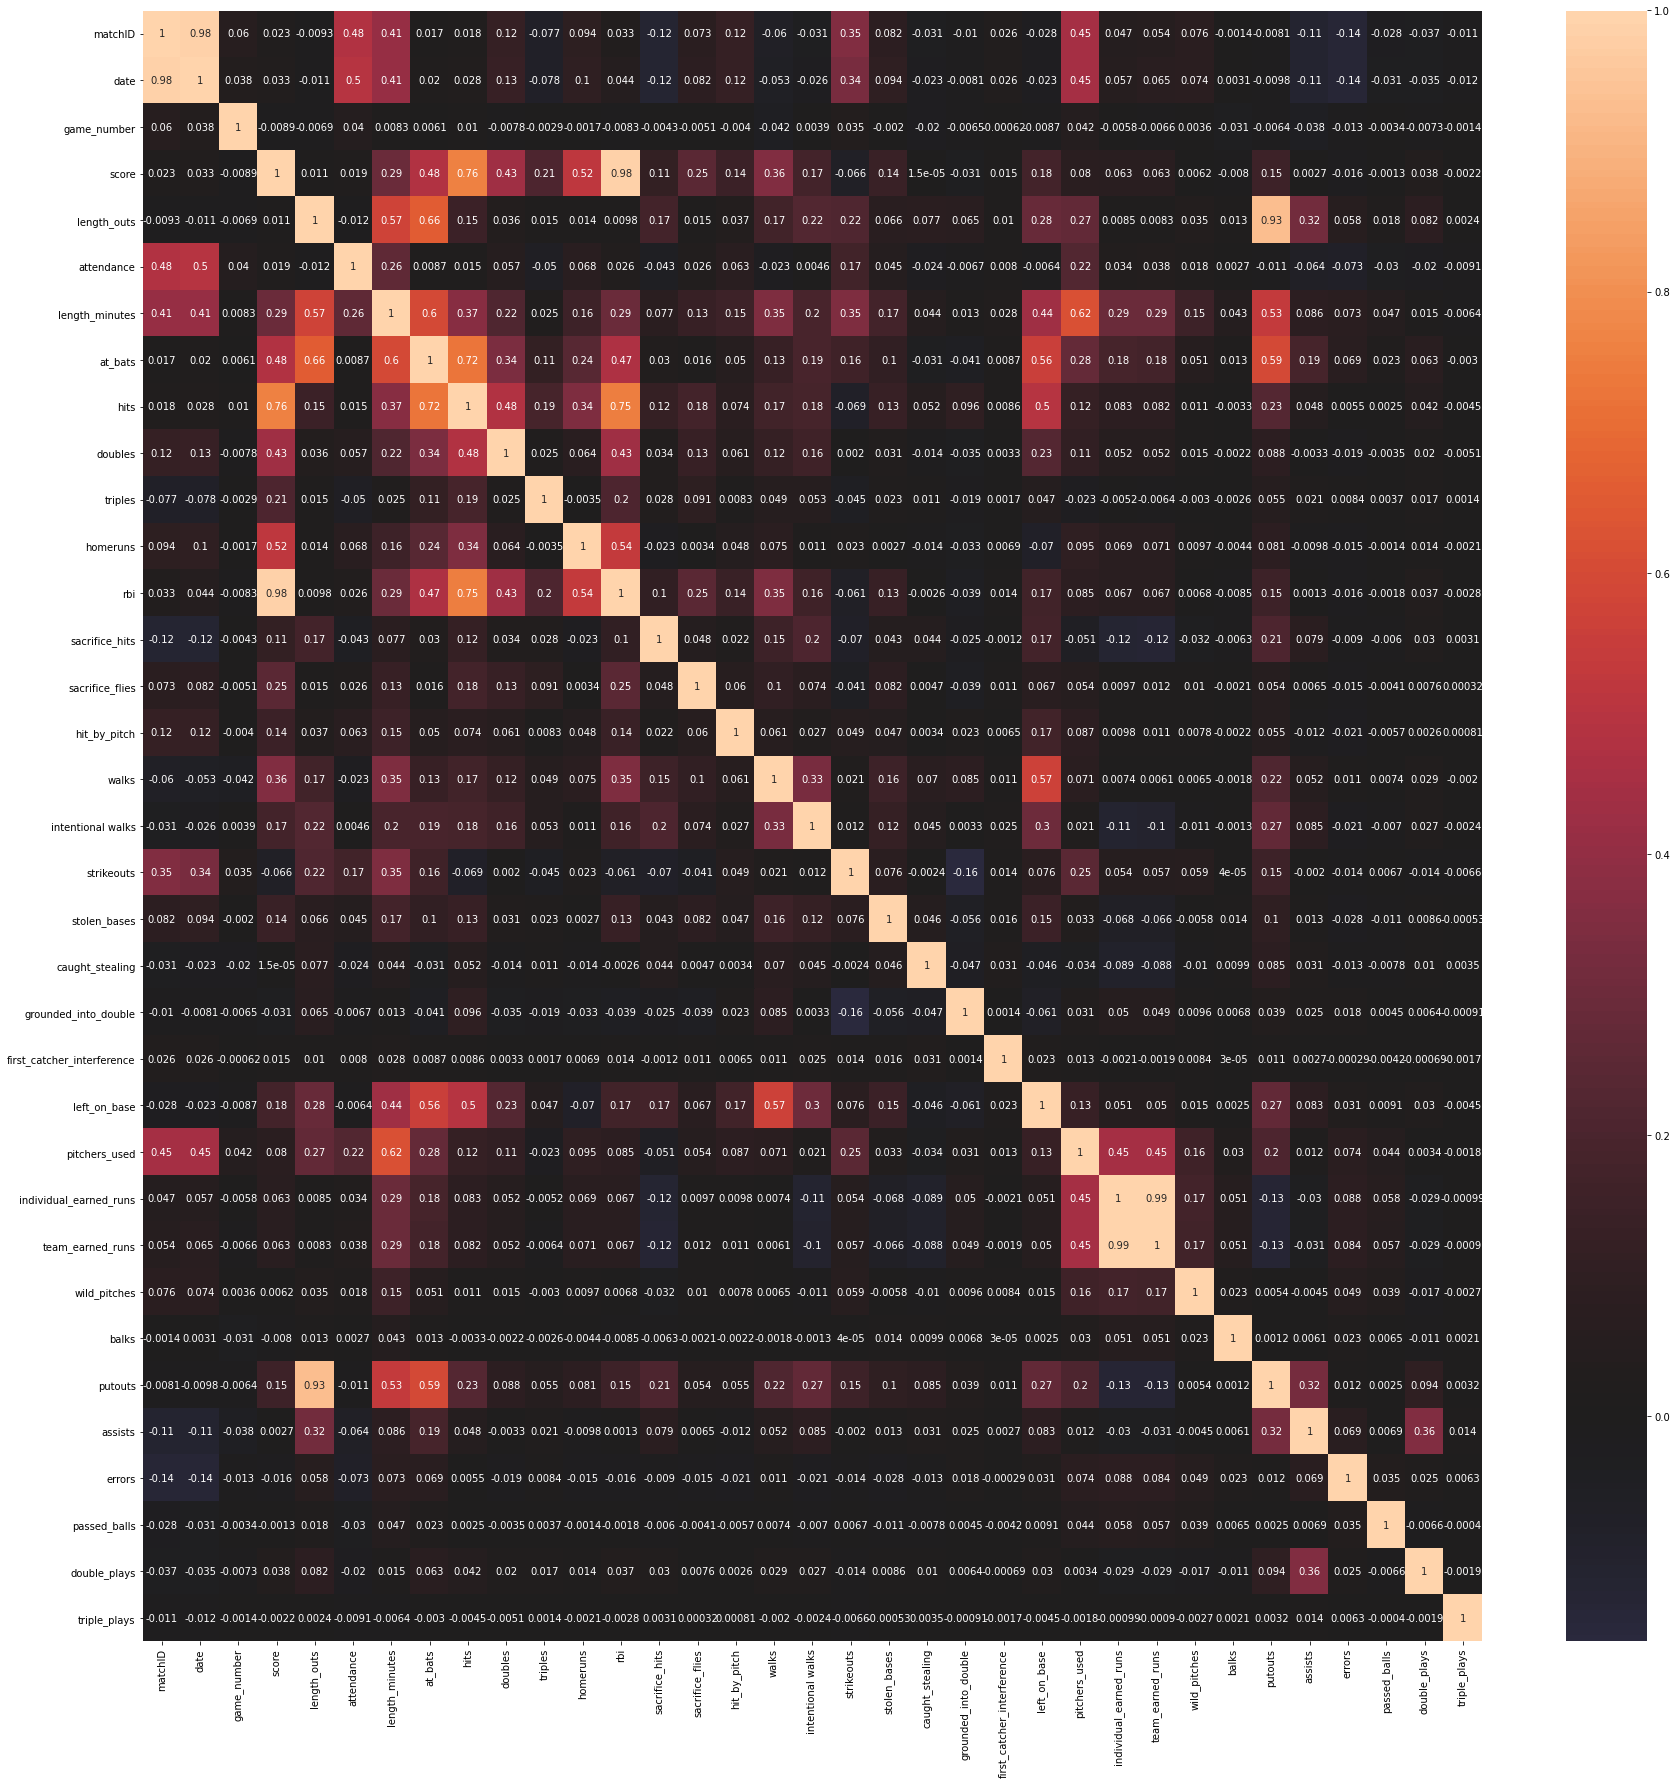

In [6]:
sns.heatmap(X.corr(), center=0, annot=True);

## Variance Inflation Factor

In [8]:
# teams = X['name'].str.get_dummies()
day = X['day_of_week'].str.get_dummies()
# dn = X['day_night'].str.get_dummies()
# X = X.join(teams)
X = X.join(day)
# X = X.join(dn)
X.drop(columns=['day_of_week'], inplace=True)

# Columns dropped after VIF analysis:
X.drop(columns=['matchID', 'score', 'length_outs', 'at_bats', 'putouts'], inplace=True)

In [7]:
Xvif = X.loc[:, :'triple_plays']

In [8]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = [variance_inflation_factor(Xvif.values, i) for i in range(Xvif.shape[1])]
list(zip(Xvif.columns, vif))

[('date', 52.25767816012181),
 ('game_number', 3.9394937437569624),
 ('attendance', 5.210154537161773),
 ('length_minutes', 93.12534866001145),
 ('hits', 101.69107571630285),
 ('doubles', 3.4815180330497313),
 ('triples', 1.312396962232327),
 ('homeruns', 2.9664037914251895),
 ('rbi', 33.882293209300656),
 ('sacrifice_hits', 1.4810336658294831),
 ('sacrifice_flies', 1.3779268271366325),
 ('hit_by_pitch', 1.6402105649807142),
 ('walks', 19.523175301288383),
 ('intentional walks', 1.5083028770956322),
 ('strikeouts', 6.825436230282698),
 ('stolen_bases', 1.513482304493216),
 ('caught_stealing', 1.6228581010542678),
 ('grounded_into_double', 3.1803784259621617),
 ('first_catcher_interference', 1.0098156072062865),
 ('left_on_base', 65.93028895516177),
 ('pitchers_used', 11.378128537076593),
 ('individual_earned_runs', 261.8516934329826),
 ('team_earned_runs', 258.97142362574857),
 ('wild_pitches', 1.32534963903639),
 ('balks', 1.0447398298345965),
 ('assists', 12.78420279145401),
 ('error

# XGBoost

In [39]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn import metrics

In [11]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.3,
                                                    random_state=42
                                                   )

# Train-Validation Split
X_train, X_validate, y_train, y_validate = train_test_split(X_train,
                                                    y_train,
                                                    test_size=0.3,
                                                    random_state=42
                                                   )

# Initialising K-Folds
kfold = KFold(n_splits=5,
              random_state=42,
              shuffle=True
             )

In [38]:
# Define function to build ROC curve
def buildROC(target_train, train_preds, target_test,test_preds):
    fpr, tpr, threshold = metrics.roc_curve(target_test, test_preds)
    roc_auc = metrics.auc(fpr, tpr)
    fpr1, tpr1, threshold = metrics.roc_curve(target_train, train_preds)
    roc_auc1 = metrics.auc(fpr1, tpr1)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr1, tpr1, 'b', label = 'Train AUC = %0.2f' % roc_auc1)
    plt.plot(fpr, tpr, 'b', label = 'Validation AUC = %0.2f' % roc_auc, color = 'g')
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.gcf().savefig('roc.png')

### Baseline XGBoost Model With No Hyperparameter Tuning

In [12]:
# Instantiate XGBoost & Fit Train Data
clf = XGBClassifier()
clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [36]:
# Predict for Train & Validation Data
training_preds = clf.predict(X_train)
validate_preds = clf.predict(X_validate)

# Calculate Accuracy for Train & Validation Data
training_roc_auc = roc_auc_score(y_train, training_preds)
validate_roc_auc = roc_auc_score(y_validate, validate_preds)

print('Training ROC_AUC: {:.4}%'.format(training_roc_auc * 100))
print('Validation ROC_AUC: {:.4}%'.format(validate_roc_auc * 100))

Training ROC_AUC: 66.48%
Validation ROC_AUC: 65.48%


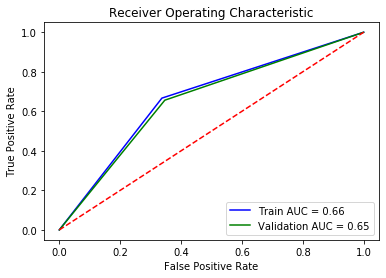

In [37]:
buildROC(y_train, training_preds, y_validate, validate_preds)

## Set Initial Values for Hyperparameter Tuning 

In [19]:
# Define parameters
param_grid = {
    'learning_rate': [0.05, 0.1, 0.25, 0.5],
    'max_depth': [5, 8, 10, 13],
    'min_child_weight': [0.1, 0.5, 1.0],
    'subsample': [1.0],
    'n_estimators': [100],
}

In [26]:
# Define parameters
param_grid = {
    'learning_rate': [0.25],
    'max_depth': [8],
    'min_child_weight': [0.1],
    'subsample': [1.0],
    'n_estimators': [100]
}

In [27]:
grid_clf = GridSearchCV(clf, param_grid, scoring='roc_auc', cv=kfold, n_jobs=-1)
grid_clf.fit(X_train, y_train)

best_parameters = grid_clf.best_params_

print('Grid Search found the following optimal parameters: ')
for param_name in sorted(best_parameters.keys()):
    print('%s: %r' % (param_name, best_parameters[param_name]))

training_preds = grid_clf.predict(X_train)
validate_preds = grid_clf.predict(X_validate)

training_roc_auc = roc_auc_score(y_train, training_preds)
validate_roc_auc = roc_auc_score(y_validate, validate_preds)

print('Training ROC_AUC: {:.4}%'.format(training_roc_auc * 100))
print('Validation ROC_AUC: {:.4}%'.format(validate_roc_auc * 100))

Grid Search found the following optimal parameters: 
learning_rate: 0.25
max_depth: 8
min_child_weight: 0.1
n_estimators: 100
subsample: 1.0
Training ROC_AUC: 82.12%
Validation ROC_AUC: 65.92%


Here, we see training score increased substantially but validation score only improved marginally. Hence, we try to create a more robust model by improving the validation score while trying to reduce overfitting to the training dataset.

In [38]:
# Define parameters
param_grid = {
    'learning_rate': [0.25, 0.3],
    'max_depth': [7, 8, 9],
    'min_child_weight': [0.05, 0.1, 0.2],
    'subsample': [1.0],
    'n_estimators': [100],
    'colsample_bytree': [0.3, 0.5, 0.8],     # Avoid some columns take too much credit for the prediction
    'gamma': [1, 5, 10],                     # Regularization
}

In [72]:
# Define parameters
param_grid = {
    'learning_rate': [0.25],
    'max_depth': [9],
    'min_child_weight': [0.05],
    'subsample': [1.0],
    'n_estimators': [100],
    'colsample_bytree': [0.8],     
    'gamma': [5],                  
}

In [73]:
grid_clf = GridSearchCV(clf, param_grid, scoring='roc_auc', cv=kfold, n_jobs=-1)
grid_clf.fit(X_train, y_train)

best_parameters = grid_clf.best_params_

print('Grid Search found the following optimal parameters: ')
for param_name in sorted(best_parameters.keys()):
    print('%s: %r' % (param_name, best_parameters[param_name]))

training_preds = grid_clf.predict(X_train)
validate_preds = grid_clf.predict(X_validate)

training_roc_auc = roc_auc_score(y_train, training_preds)
validate_roc_auc = roc_auc_score(y_validate, validate_preds)

print('Training ROC_AUC: {:.4}%'.format(training_roc_auc * 100))
print('Validation ROC_AUC: {:.4}%'.format(validate_roc_auc * 100))

# Grid Search found the following optimal parameters: 
# colsample_bytree: 0.8
# gamma: 5
# learning_rate: 0.25
# max_depth: 9
# min_child_weight: 0.05
# n_estimators: 100
# subsample: 1.0
# Training ROC_AUC: 78.79%
# Validation ROC_AUC: 66.08%

Grid Search found the following optimal parameters: 
colsample_bytree: 0.8
gamma: 5
learning_rate: 0.25
max_depth: 9
min_child_weight: 0.05
n_estimators: 100
subsample: 1.0
Training ROC_AUC: 78.79%
Validation ROC_AUC: 66.08%


After second round of tuning, we see slightly improved figures, with slightly higher validation score and less overfit shown by the reduction in difference between training and validation score.

In [88]:
# Define parameters
param_grid = {
    'learning_rate': [0.05, 0.15, 0.25],
    'max_depth': [9],
    'min_child_weight': [1, 2, 4, 6, 8],
    'subsample': [1],
    'n_estimators': [10, 35, 50],
    'colsample_bytree': [0.93],     
    'gamma': [5],                   
}

In [20]:
param_grid = {
    "learning_rate"    : [0.05] ,
     "max_depth"        : [9],
     "min_child_weight" : [6],
    "subsample"         : [1],
     "gamma"            : [5],
     "colsample_bytree" : [0.93],
     "n_estimators": [35]
}

In [21]:
grid_clf = GridSearchCV(clf, param_grid, scoring='roc_auc', cv=kfold, n_jobs=-1)
grid_clf.fit(X_train, y_train)

best_parameters = grid_clf.best_params_

print('Grid Search found the following optimal parameters: ')
for param_name in sorted(best_parameters.keys()):
    print('%s: %r' % (param_name, best_parameters[param_name]))

training_preds = grid_clf.predict(X_train)
validate_preds = grid_clf.predict(X_validate)

training_roc_auc = roc_auc_score(y_train, training_preds)
validate_roc_auc = roc_auc_score(y_validate, validate_preds)

print('Training ROC_AUC: {:.4}%'.format(training_roc_auc * 100))
print('Validation ROC_AUC: {:.4}%'.format(validate_roc_auc * 100))

Grid Search found the following optimal parameters: 
colsample_bytree: 0.93
gamma: 5
learning_rate: 0.05
max_depth: 9
min_child_weight: 6
n_estimators: 35
subsample: 1
Training ROC_AUC: 71.14%
Validation ROC_AUC: 66.69%


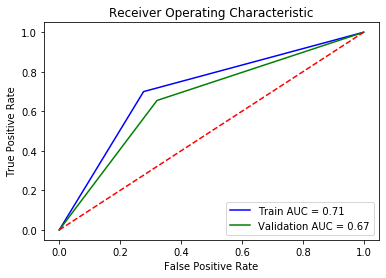

In [33]:
buildROC(y_train, training_preds, y_validate, validate_preds)

In [ ]:
# make predictions for test data and evaluate
y_pred = grid_clf.predict(X_test)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
# Fit model using each importance as a threshold
thresholds = sort(model.feature_importances_)
for thresh in thresholds:
# select features using threshold
selection = SelectFromModel(model, threshold=thresh, prefit=True)
select_X_train = selection.transform(X_train)
# train model
selection_model = XGBClassifier()
selection_model.fit(select_X_train, y_train)
# eval model
select_X_test = selection.transform(X_test)
y_pred = selection_model.predict(select_X_test)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions)
print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))


# ALL USING ACCURACY

In [14]:
# Predict for Train & Validation Data
training_preds = clf.predict(X_train)
validate_preds = clf.predict(X_validate)
test_preds = clf.predict(X_test)

# Calculate Accuracy for Train & Validation Data
training_accuracy = accuracy_score(y_train, training_preds)
validate_accuracy = accuracy_score(y_validate, validate_preds)
test_accuracy = accuracy_score(y_test, test_preds)

print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print('Validation accuracy: {:.4}%'.format(validate_accuracy * 100))
print('Test accuracy: {:.4}%'.format(test_accuracy * 100))

# Training Accuracy: 66.4%
# Validation accuracy: 65.72%
# Test accuracy: 65.63%

Training Accuracy: 66.4%
Validation accuracy: 65.72%
Test accuracy: 65.63%


In [26]:
# Define parameters
param_grid = {
    'learning_rate': [0.05, 0.15, 0.25, 0.35],
    'max_depth': [6, 7, 8],
    'min_child_weight': [0.5],
    'subsample': [1.0],
    'n_estimators': [100, 500, 1000],
}

In [27]:
grid_clf = GridSearchCV(clf, param_grid, scoring='accuracy', cv=kfold, n_jobs=-1)
grid_clf.fit(X_train, y_train)

best_parameters = grid_clf.best_params_

print('Grid Search found the following optimal parameters: ')
for param_name in sorted(best_parameters.keys()):
    print('%s: %r' % (param_name, best_parameters[param_name]))

training_preds = grid_clf.predict(X_train)
validate_preds = grid_clf.predict(X_validate)
test_preds = grid_clf.predict(X_test)

training_accuracy = accuracy_score(y_train, training_preds)
validate_accuracy = accuracy_score(y_validate, validate_preds)
test_accuracy = accuracy_score(y_test, test_preds)

print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print('Validation accuracy: {:.4}%'.format(validate_accuracy * 100))
print('Test accuracy: {:.4}%'.format(test_accuracy * 100))

Grid Search found the following optimal parameters: 
learning_rate: 0.05
max_depth: 8
min_child_weight: 0.5
n_estimators: 1000
subsample: 1.0
Training Accuracy: 90.0%
Validation accuracy: 72.29%
Test accuracy: 72.29%


In [12]:
# Both provide same results as below
param_grid = {
    'learning_rate': [0.25, 0.3, 0.35],
    'max_depth': [8, 10, 12],
    'min_child_weight': [0.45, 0.5, 55],
    'subsample': [1.0],
    'n_estimators': [100],
}

param_grid = {
    'learning_rate': [0.15, 0.2, 0.25],
    'max_depth': [4, 6, 8],
    'min_child_weight': [0.5],
    'subsample': [1.0],
    'n_estimators': [100],
}

In [16]:
from sklearn.model_selection import GridSearchCV

grid_clf = GridSearchCV(clf, param_grid, scoring='accuracy', cv=kfold, n_jobs=-1)
grid_clf.fit(X_train, y_train)

best_parameters = grid_clf.best_params_

print('Grid Search found the following optimal parameters: ')
for param_name in sorted(best_parameters.keys()):
    print('%s: %r' % (param_name, best_parameters[param_name]))

training_preds = grid_clf.predict(X_train)
validate_preds = grid_clf.predict(X_validate)
test_preds = grid_clf.predict(X_test)

training_accuracy = accuracy_score(y_train, training_preds)
validate_accuracy = accuracy_score(y_validate, validate_preds)
test_accuracy = accuracy_score(y_test, test_preds)

print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print('Validation accuracy: {:.4}%'.format(validate_accuracy * 100))
print('Test accuracy: {:.4}%'.format(test_accuracy * 100))

Grid Search found the following optimal parameters: 
learning_rate: 0.25
max_depth: 8
min_child_weight: 0.5
n_estimators: 100
subsample: 1.0
Training Accuracy: 84.95%
Validation accuracy: 71.3%
Test accuracy: 71.43%


### Best Model with least overfit with all parameters

In [53]:
# Define parameters
param_grid = {
    'learning_rate': [0.25],
    'max_depth': [8],
    'min_child_weight': [0.5],
    'subsample': [1.0],
    'n_estimators': [100],
    'colsample_bytree': [0.3, 0.5, 0.8],     # Avoid some columns take too much credit for the prediction
    'gamma': [0, 1, 5]                       # Regularization
}

In [51]:
from sklearn.model_selection import GridSearchCV

grid_clf = GridSearchCV(clf, param_grid, scoring='accuracy', cv=kfold, n_jobs=-1)
grid_clf.fit(X_train, y_train)

best_parameters = grid_clf.best_params_

print('Grid Search found the following optimal parameters: ')
for param_name in sorted(best_parameters.keys()):
    print('%s: %r' % (param_name, best_parameters[param_name]))

training_preds = grid_clf.predict(X_train)
validate_preds = grid_clf.predict(X_validate)
test_preds = grid_clf.predict(X_test)

training_accuracy = accuracy_score(y_train, training_preds)
validate_accuracy = accuracy_score(y_validate, validate_preds)
test_accuracy = accuracy_score(y_test, test_preds)

print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print('Validation accuracy: {:.4}%'.format(validate_accuracy * 100))
print('Test accuracy: {:.4}%'.format(test_accuracy * 100))

# Grid Search found the following optimal parameters: 
# colsample_bytree: 0.8
# gamma: 5
# learning_rate: 0.25
# max_depth: 8
# min_child_weight: 0.5
# n_estimators: 100
# subsample: 1.0
# Training Accuracy: 80.45%
# Validation accuracy: 71.0%
# Test accuracy: 71.18%

Grid Search found the following optimal parameters: 
colsample_bytree: 0.8
gamma: 5
learning_rate: 0.25
max_depth: 8
min_child_weight: 0.5
n_estimators: 100
subsample: 1.0
Training Accuracy: 80.45%
Validation accuracy: 71.0%
Test accuracy: 71.18%


### Tuning n_estimators (Best Validation & Test Data)

In [57]:
# Define parameters
param_grid = {
    'learning_rate': [0.25],
    'max_depth': [8],
    'min_child_weight': [0.5],
    'subsample': [1.0],
    'n_estimators': [100, 500, 1000],
    'colsample_bytree': [0.8],     # Avoid some columns take too much credit for the prediction
    'gamma': [5],                  # Regularization
}

In [58]:
from sklearn.model_selection import GridSearchCV

grid_clf = GridSearchCV(clf, param_grid, scoring='accuracy', cv=kfold, n_jobs=-1)
grid_clf.fit(X_train, y_train)

best_parameters = grid_clf.best_params_

print('Grid Search found the following optimal parameters: ')
for param_name in sorted(best_parameters.keys()):
    print('%s: %r' % (param_name, best_parameters[param_name]))

training_preds = grid_clf.predict(X_train)
validate_preds = grid_clf.predict(X_validate)
test_preds = grid_clf.predict(X_test)

training_accuracy = accuracy_score(y_train, training_preds)
validate_accuracy = accuracy_score(y_validate, validate_preds)
test_accuracy = accuracy_score(y_test, test_preds)

print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print('Validation accuracy: {:.4}%'.format(validate_accuracy * 100))
print('Test accuracy: {:.4}%'.format(test_accuracy * 100))

# Grid Search found the following optimal parameters: 
# colsample_bytree: 0.8
# gamma: 5
# learning_rate: 0.25
# max_depth: 8
# min_child_weight: 0.5
# n_estimators: 1000
# subsample: 1.0
# Training Accuracy: 85.44%
# Validation accuracy: 72.28%
# Test accuracy: 72.18%

Grid Search found the following optimal parameters: 
colsample_bytree: 0.8
gamma: 5
learning_rate: 0.25
max_depth: 8
min_child_weight: 0.5
n_estimators: 1000
subsample: 1.0
Training Accuracy: 85.44%
Validation accuracy: 72.28%
Test accuracy: 72.18%


In [ ]:
# Predict for Train & Validation Data
training_preds = clf.predict(X_train)
validate_preds = clf.predict(X_validate)

# Calculate Accuracy for Train & Validation Data
training_accuracy = accuracy_score(y_train, training_preds)
validate_accuracy = accuracy_score(y_validate, validate_preds)

print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print('Validation accuracy: {:.4}%'.format(validate_accuracy * 100))

# Training Accuracy: 66.4%
# Validation accuracy: 65.72%

In [ ]:
from sklearn.model_selection import GridSearchCV

grid_clf = GridSearchCV(clf, param_grid, scoring='accuracy', cv=kfold, n_jobs=-1)
grid_clf.fit(X_train, y_train)

best_parameters = grid_clf.best_params_

print('Grid Search found the following optimal parameters: ')
for param_name in sorted(best_parameters.keys()):
    print('%s: %r' % (param_name, best_parameters[param_name]))

training_preds = grid_clf.predict(X_train)
validate_preds = grid_clf.predict(X_validate)

training_accuracy = accuracy_score(y_train, training_preds)
validate_accuracy = accuracy_score(y_validate, validate_preds)

print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print('Validation accuracy: {:.4}%'.format(validate_accuracy * 100))

# Grid Search found the following optimal parameters: 
# learning_rate: 0.35
# max_depth: 7
# min_child_weight: 0.5
# n_estimators: 100
# subsample: 1.0
# Training Accuracy: 82.97%
# Validation accuracy: 71.4%

In [ ]:
from sklearn.model_selection import GridSearchCV

grid_clf = GridSearchCV(clf, param_grid, scoring='accuracy', cv=kfold, n_jobs=-1)
grid_clf.fit(X_train, y_train)

best_parameters = grid_clf.best_params_

print('Grid Search found the following optimal parameters: ')
for param_name in sorted(best_parameters.keys()):
    print('%s: %r' % (param_name, best_parameters[param_name]))

training_preds = grid_clf.predict(X_train)
validate_preds = grid_clf.predict(X_validate)

training_accuracy = accuracy_score(y_train, training_preds)
validate_accuracy = accuracy_score(y_validate, validate_preds)

print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print('Validation accuracy: {:.4}%'.format(validate_accuracy * 100))

# Grid Search found the following optimal parameters: 
# colsample_bytree: 0.8
# gamma: 5
# learning_rate: 0.25
# max_depth: 8
# min_child_weight: 0.5
# n_estimators: 100
# subsample: 1.0
# Training Accuracy: 80.45%
# Validation accuracy: 71.0%

In [ ]:
from sklearn.model_selection import GridSearchCV

grid_clf = GridSearchCV(clf, param_grid, scoring='accuracy', cv=kfold, n_jobs=-1)
grid_clf.fit(X_train, y_train)

best_parameters = grid_clf.best_params_

print('Grid Search found the following optimal parameters: ')
for param_name in sorted(best_parameters.keys()):
    print('%s: %r' % (param_name, best_parameters[param_name]))

training_preds = grid_clf.predict(X_train)
validate_preds = grid_clf.predict(X_validate)

training_accuracy = accuracy_score(y_train, training_preds)
validate_accuracy = accuracy_score(y_validate, validate_preds)

print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print('Validation accuracy: {:.4}%'.format(validate_accuracy * 100))

# Grid Search found the following optimal parameters: 
# colsample_bytree: 0.8
# gamma: 5
# learning_rate: 0.25
# max_depth: 8
# min_child_weight: 0.5
# n_estimators: 1000
# subsample: 1.0
# Training Accuracy: 85.44%
# Validation accuracy: 72.28%